# IMPORTAÇÕES

In [4]:
# Importação de bibliotecas

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# CARREGAR OS DADOS

In [5]:
# Carregar dados
drive.mount('/content/drive')
#data = pd.read_csv('/content/drive/MyDrive/07_per_shared/projCDat_25_1/datasets/cooked/_all/all_merged.csv')

data = pd.read_csv('/content/drive/MyDrive/projCDat_25_1/datasets/cooked/_all/all_merged.csv')

# Visualizar as primeiras linhas
print(data.head())

# Verificar estatísticas básicas
print(data.describe())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   _ano _estado  _mes  car_c02_emitido  cli_pressao_atm_med  cli_temp_ar_med  \
0  2008      AC     7     2.627698e+07           986.843612        28.142731   
1  2008      AC     9     2.627698e+07           991.705941        24.446194   
2  2008      AC    10     2.627698e+07           990.328360        25.229298   
3  2008      AC    11     2.627698e+07           988.610987        25.195410   
4  2008      AC    12     2.627698e+07           988.692608        24.898790   

   cli_temp_orvalho_med  cli_umid_rel_med  cli_umid_rel_min_max  \
0             18.914978         59.555066                  95.0   
1             19.467987         75.811881                  97.0   
2             21.617473         81.870968                  96.0   
3             22.624478         86.905424                  96.0   
4             22.727554         88.529570              

## Exibindo um gráfico de dispersão Área Queimada vs. Emissão de CO2

In [6]:

# Calcular e exibir o coeficiente de correlação de Pearson
correlation = data['que_area_queimada'].corr(data['car_c02_emitido'])
print(f"Coeficiente de Correlação entre Área Queimada e Emissão de CO2: {correlation:.2f}")

Coeficiente de Correlação entre Área Queimada e Emissão de CO2: 0.19


# Preparar os dados e treinar o modelo

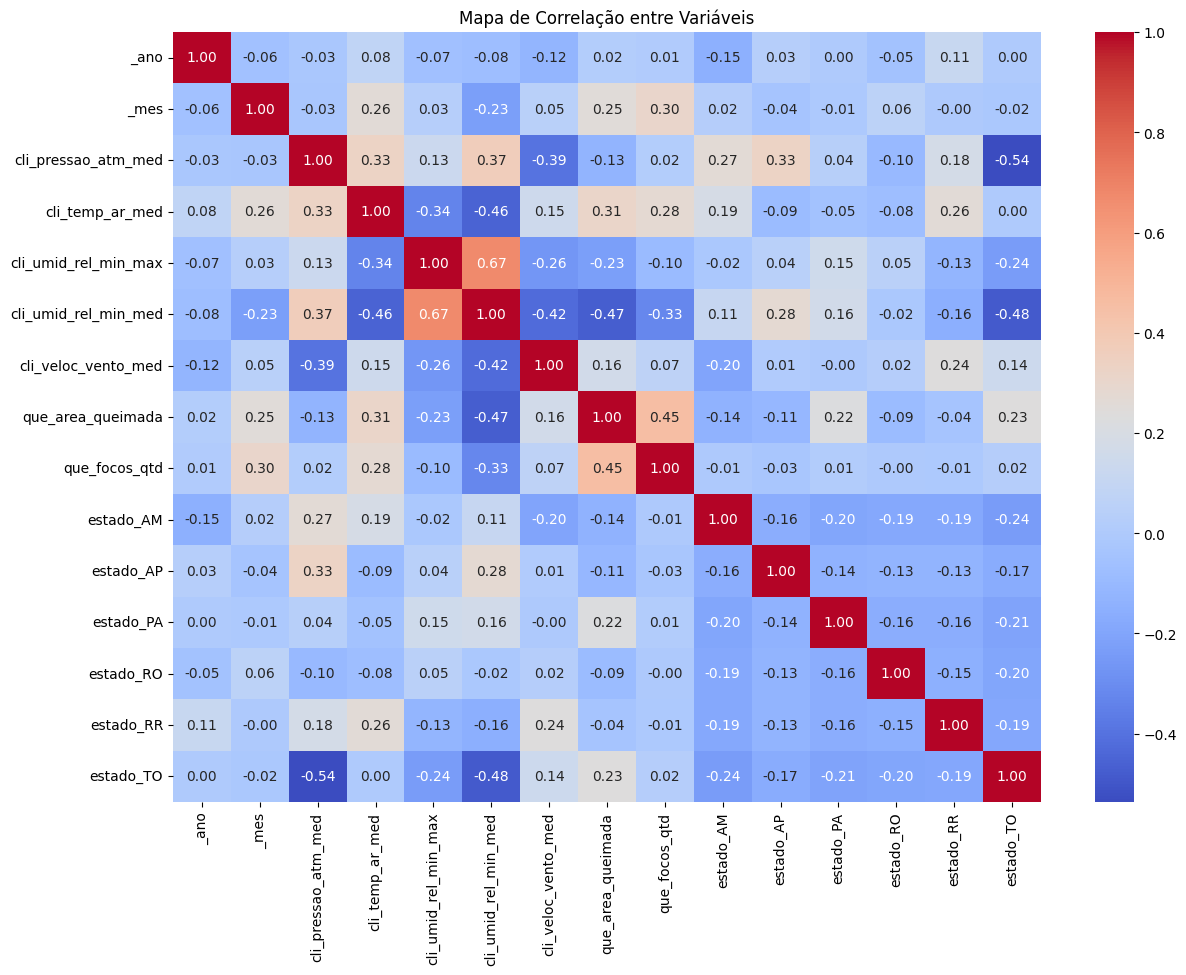

=== VIF por variável ===
                variável            VIF
0                  const  192758.904249
1                   _ano       1.173237
2                   _mes       1.306967
3    cli_pressao_atm_med       3.325461
4        cli_temp_ar_med       2.361384
5   cli_umid_rel_min_max       2.263059
6   cli_umid_rel_min_med       5.040049
7    cli_veloc_vento_med       1.983190
8      que_area_queimada       1.770625
9          que_focos_qtd       1.453012
10             estado_AM       2.843583
11             estado_AP       2.466408
12             estado_PA       2.397923
13             estado_RO       2.201466
14             estado_RR       2.794510
15             estado_TO       3.489582
Coeficientes: [ 1.21691096e+07  2.05607234e+06  4.30947599e+07 -1.17255458e+07
  1.52796195e+06  3.57780406e+06  3.09226630e+07 -1.90093098e+06
  4.44911421e+06  9.12218839e+06 -3.07386976e+07  1.13891939e+08
  1.82941598e+07 -2.15796101e+07  1.70738497e+07]
Intercepto (b0): 104498361.29350257


In [7]:
# Cria colunas dummy (evita multicolinearidade nas dummies com drop_first=True)
data = pd.get_dummies(data, columns=['_estado'], prefix='estado', drop_first=True)

# Remover variáveis com alta multicolinearidade
variaveis_a_remover = [
    'cli_temp_orvalho_med',
    'cli_umid_rel_med',
    'cli_umid_rel_min_min',
    'cli_veloc_vento_max'
]
data = data.drop(columns=variaveis_a_remover)

# Definir X (variáveis preditoras) e y (variável alvo)
X = data.drop('car_c02_emitido', axis=1)
y = data['car_c02_emitido']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Converter colunas booleanas para inteiras (necessário para statsmodels/VIF)
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include='bool').columns})

# Mapa de correlação
plt.figure(figsize=(14,10))
sns.heatmap(X_train.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Mapa de Correlação entre Variáveis")
plt.show()

# Calcular VIF para checar multicolinearidade
X_vif = sm.add_constant(X_train)
vif_data = pd.DataFrame()
vif_data['variável'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("=== VIF por variável ===")
print(vif_data)

# Continuar com pipeline de regressão
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

print("Coeficientes:", model.coef_)
print("Intercepto (b0):", model.intercept_)


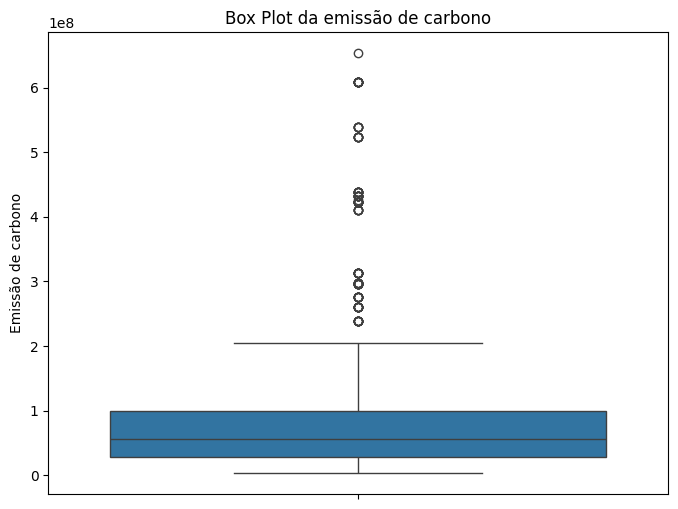

In [8]:
# fazer box plot de ytrain

plt.figure(figsize=(8, 6)) # Define o tamanho da figura
sns.boxplot(y=y_train)
plt.title('Box Plot da emissão de carbono')
plt.ylabel('Emissão de carbono') # Substitua pelo nome apropriado
plt.show()

In [9]:
menos_outliers = data[data["que_area_queimada"]<1.5e6]["que_area_queimada"]

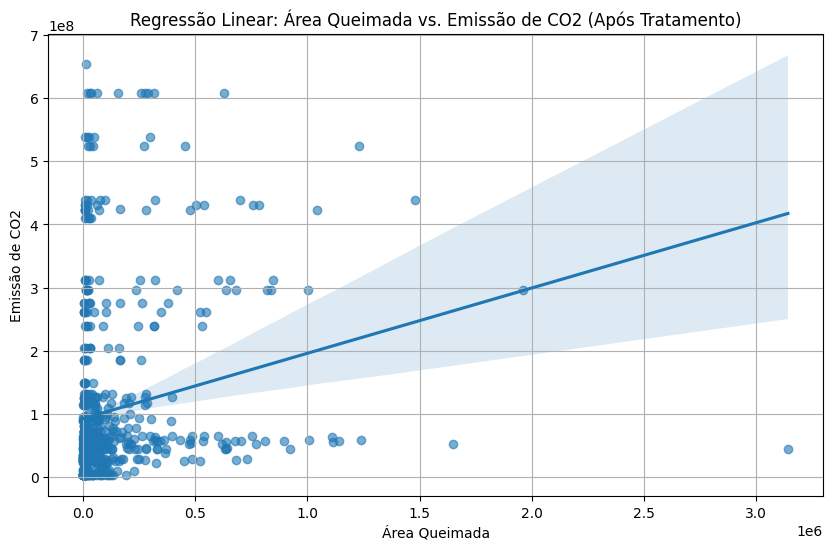

In [10]:
 # Gráfico de dispersão com a reta de regressão para Área Queimada vs. Emissão de CO2 após o tratamento

data_train_plot_treated = pd.concat([X_train, y_train], axis=1)

plt.figure(figsize=(10, 6))
sns.regplot(data=data_train_plot_treated, x='que_area_queimada', y='car_c02_emitido', scatter_kws={'alpha':0.6})
plt.title('Regressão Linear: Área Queimada vs. Emissão de CO2 (Após Tratamento)')
plt.xlabel('Área Queimada')
plt.ylabel('Emissão de CO2')
plt.grid(True)
plt.show()

# Fazer previsões e avaliar o modelo

In [11]:
# Prever valores
y_pred = model.predict(X_test)

# Métricas de avaliação
r2 = r2_score(y_test, y_pred)  # Quanto mais perto de 1, melhor
mse = mean_squared_error(y_test, y_pred)  # Erro médio quadrático
mae = mean_absolute_error(y_test, y_pred) # Calcular o MAE
variancia_y_test = y_test.var() # Calcular e exibir a variância da variável alvo no conjunto de teste


print(f"R² (Acurácia da regressao linear): {r2:.2e}")
print(f"MSE (Erro Quadrático Médio da regressao linear): {mse:.2e}")
print(f"MAE (Erro Absoluto Médio da regressão linear): {mae:.2e}") # Exibir o MAE
print(f"Variância de y_test: {variancia_y_test:.2e}")

R² (Acurácia da regressao linear): -1.25e+07
MSE (Erro Quadrático Médio da regressao linear): 2.54e+23
MAE (Erro Absoluto Médio da regressão linear): 2.00e+11
Variância de y_test: 2.03e+16


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


# Análise estatística e com OLS

In [12]:
print(X_train.dtypes)
print(y_train.dtypes)

_ano                      int64
_mes                      int64
cli_pressao_atm_med     float64
cli_temp_ar_med         float64
cli_umid_rel_min_max    float64
cli_umid_rel_min_med    float64
cli_veloc_vento_med     float64
que_area_queimada       float64
que_focos_qtd           float64
estado_AM                 int64
estado_AP                 int64
estado_PA                 int64
estado_RO                 int64
estado_RR                 int64
estado_TO                 int64
dtype: object
float64


In [13]:
# Adicionar uma constante (intercepto β0)
X_train = X_train.astype({col: 'float' for col in X_train.select_dtypes(include='bool').columns})
X_sm = sm.add_constant(X_train)

# Treina o modelo OLS (Ordinary Least Squares)
model_sm = sm.OLS(y_train, X_sm).fit()

# Resumo detalhado (p-valores, R² ajustado, etc.)
print(model_sm.summary())

print("Estatísticas de y_train:")
print(y_train.describe())  # Média, mediana, mínimo, máximo, etc.

print("\nEstatísticas de y_test:")
print(y_test.describe())

                            OLS Regression Results                            
Dep. Variable:        car_c02_emitido   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     372.5
Date:                Fri, 06 Jun 2025   Prob (F-statistic):          1.01e-321
Time:                        19:33:45   Log-Likelihood:                -13627.
No. Observations:                 717   AIC:                         2.729e+04
Df Residuals:                     701   BIC:                         2.736e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -6.948e+09 

In [14]:
# Adicionar uma constante (intercepto β0) para o conjunto de teste
X_test_sm = sm.add_constant(X_test) # Define X_test_sm by adding a constant to X_test


# 3. Gere as previsões no conjunto de teste usando o modelo treinado
y_pred_sm = model_sm.predict(X_test_sm)

# 4. Calcule as métricas com scikit-learn
r2_sm = r2_score(y_test, y_pred_sm) # Store statsmodels R2 in a separate variable
mse_sm = mean_squared_error(y_test, y_pred_sm) # Store statsmodels MSE in a separate variable
mae_sm = sm.tools.eval_measures.meanabs(y_test, y_pred_sm)
rmse_sm = sm.tools.eval_measures.rmse(y_test, y_pred_sm)




# 5. Exiba os resultados
print(f"R² (Acurácia) (statsmodels): {r2_sm:.4f}")
print(f"MSE (Erro Quadrático Médio) (statsmodels): {mse_sm:.2f}")
print(f"MAE (statsmodels): {mae_sm:.2f}")
print(f"RMSE (statsmodels): {rmse_sm:.2f}")


R² (Acurácia) (statsmodels): 0.9138
MSE (Erro Quadrático Médio) (statsmodels): 1743826548125628.25
MAE (statsmodels): 27682784.66
RMSE (statsmodels): 41759149.27


# Visualização dos dados

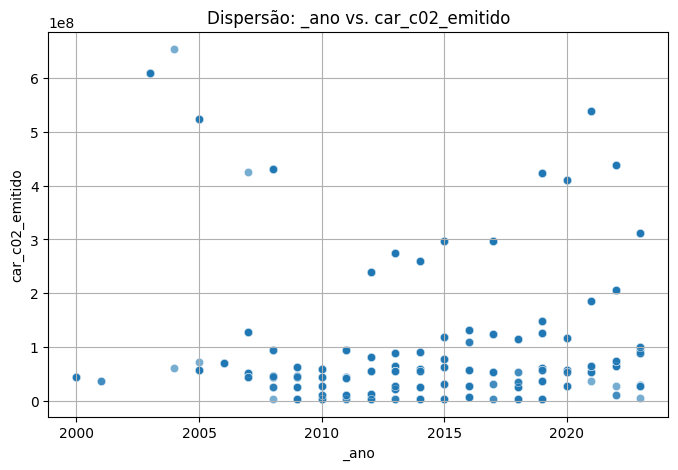

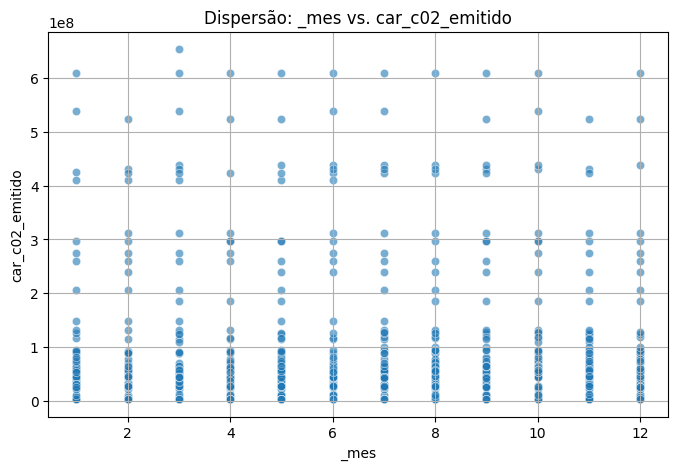

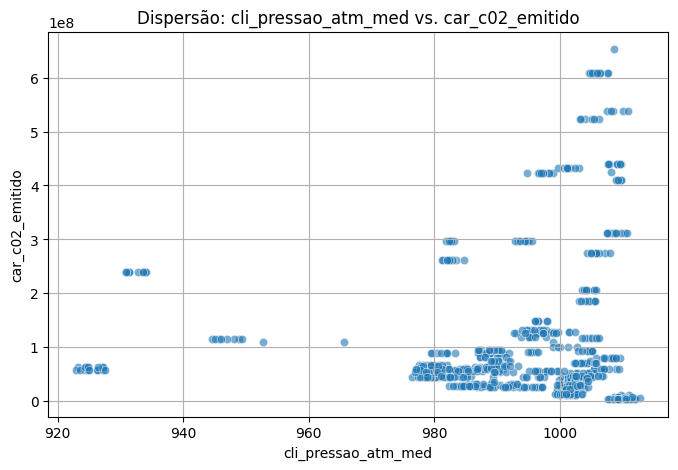

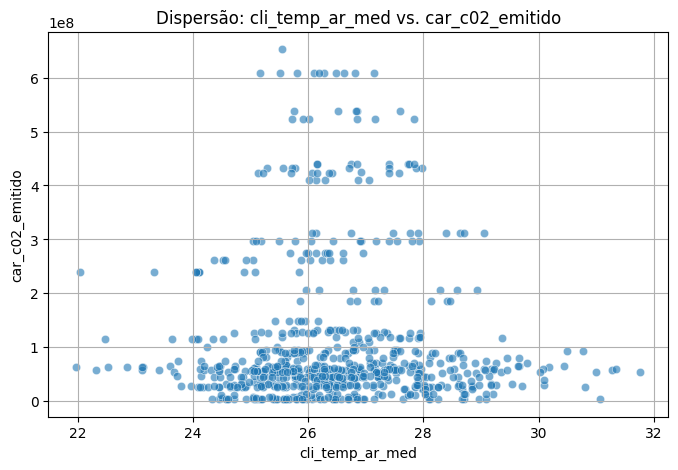

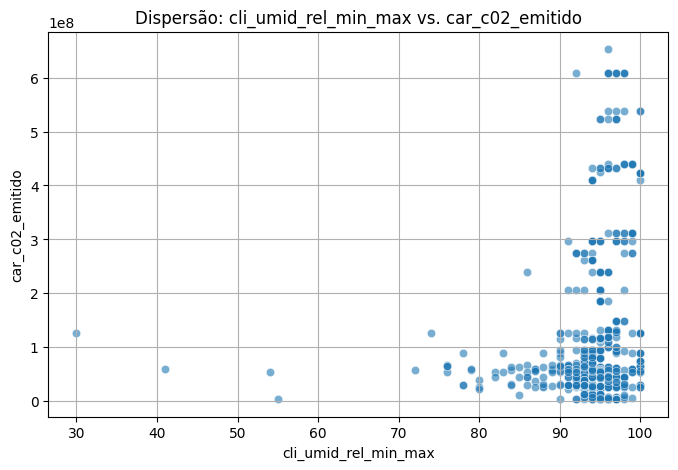

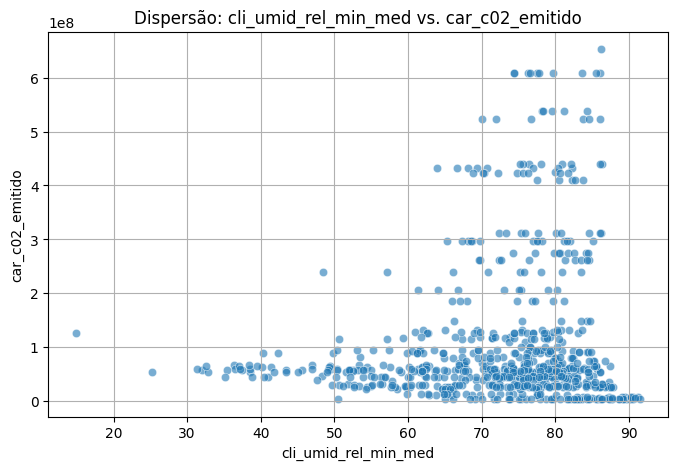

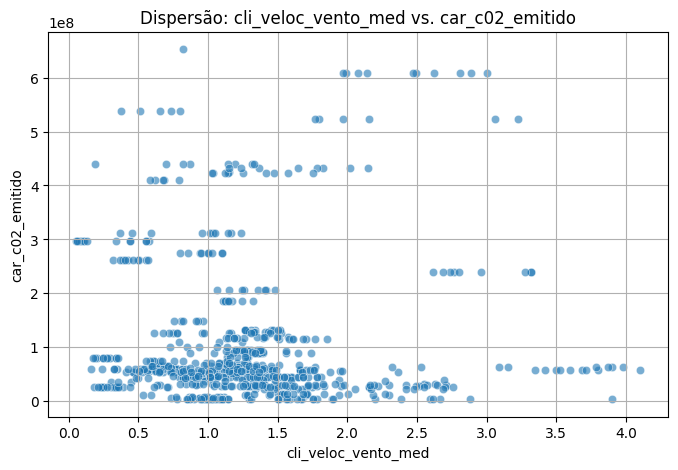

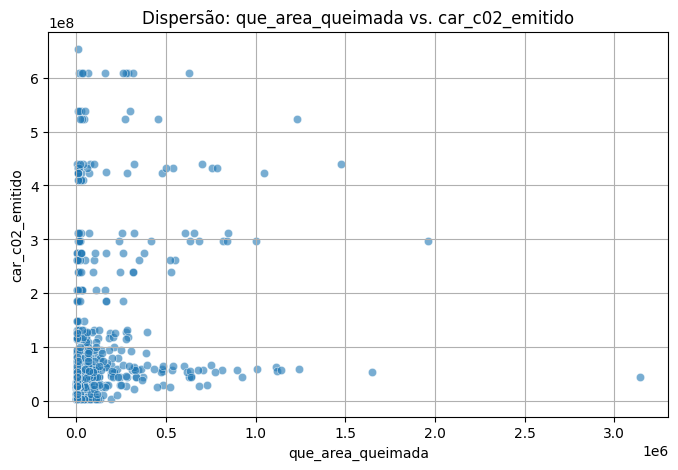

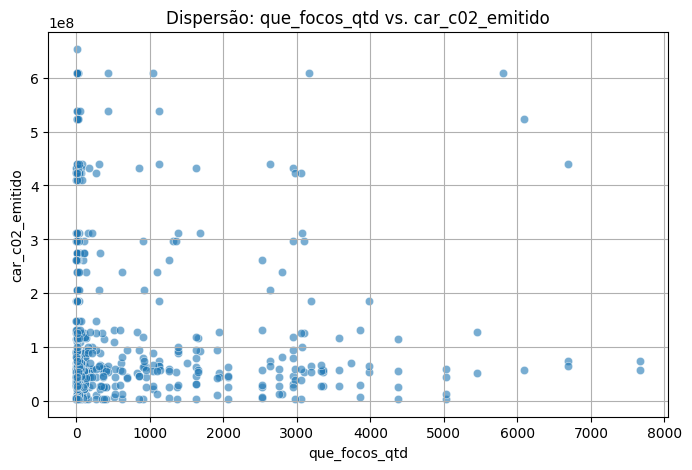

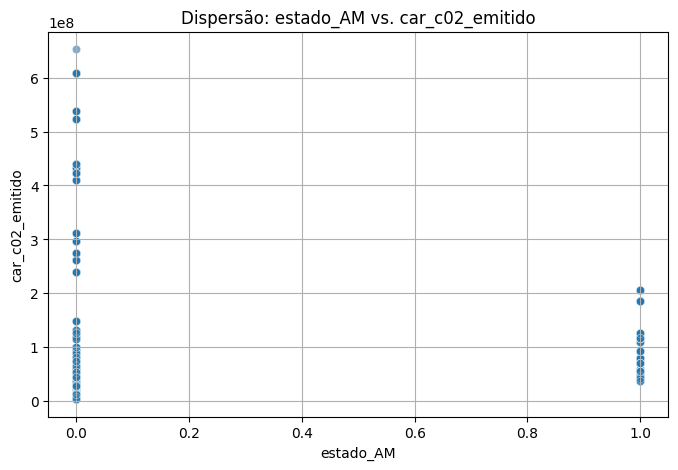

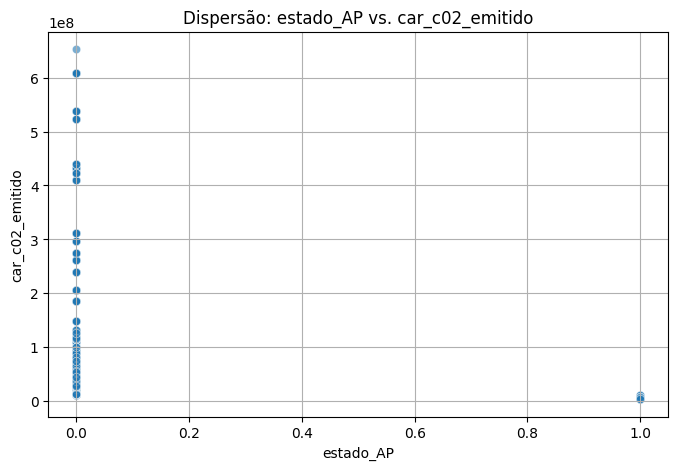

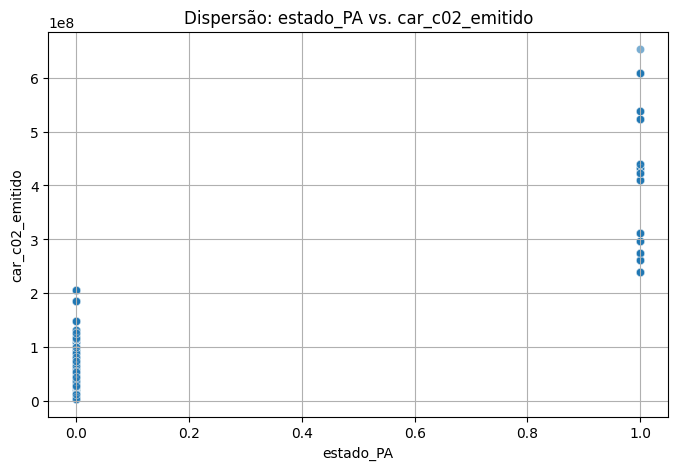

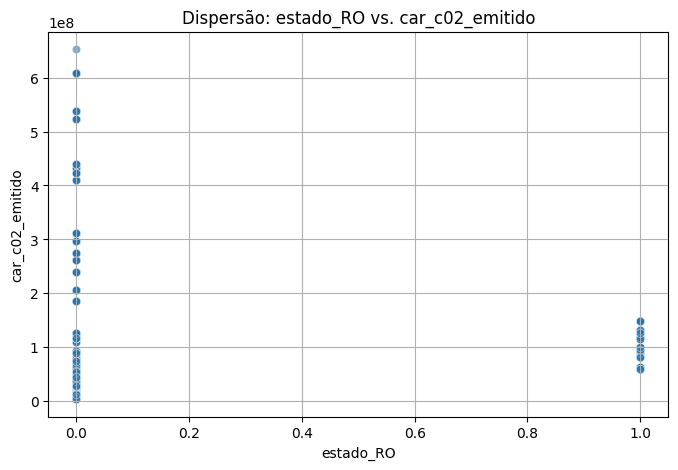

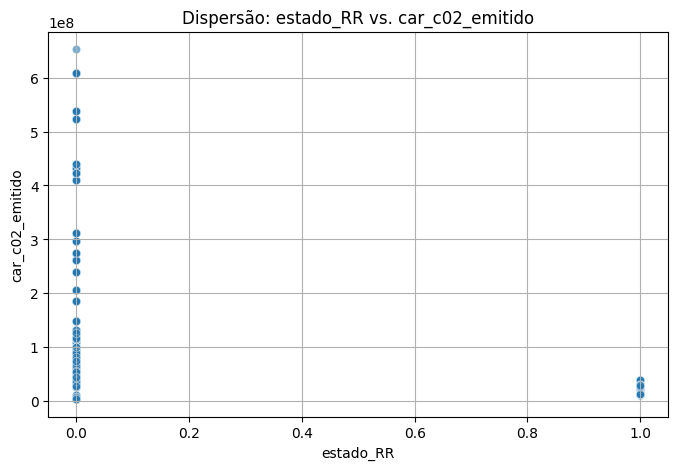

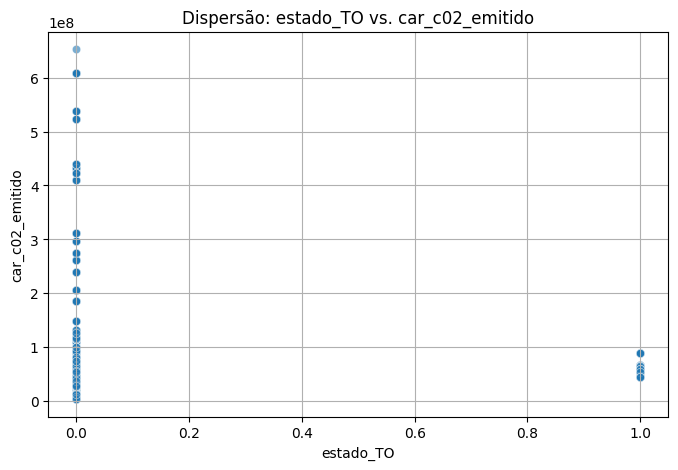

In [15]:
# # Gráficos de Dispersão: Variáveis Preditoras vs. Variável Alvo
# %%
# Juntar X_train e y_train para facilitar a plotagem
# Certifique-se de que os índices estão alinhados
data_train_plot = pd.concat([X_train, y_train], axis=1)

# Obter a lista de variáveis preditoras
preditoras = X_train.columns

# Criar gráficos de dispersão para cada preditora vs. alvo
for col in preditoras:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=data_train_plot, x=col, y='car_c02_emitido', alpha=0.6)
    plt.title(f'Dispersão: {col} vs. car_c02_emitido')
    plt.xlabel(col)
    plt.ylabel('car_c02_emitido')
    plt.grid(True)
    plt.show()

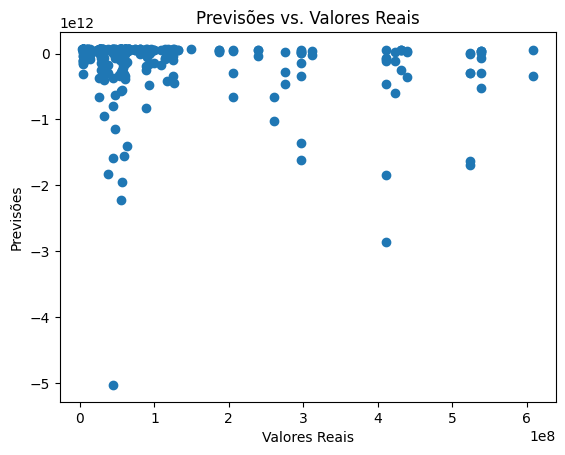

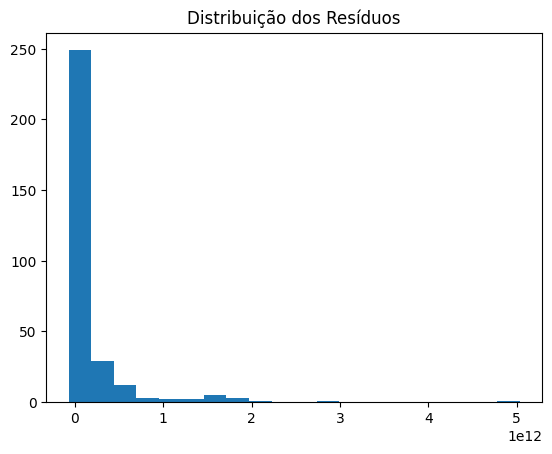

In [16]:
# Gráfico de resíduos (erros)
plt.scatter(y_test, y_pred)
plt.xlabel("Valores Reais")
plt.ylabel("Previsões")
plt.title("Previsões vs. Valores Reais")
plt.show()

# Histograma dos resíduos
residuos = y_test - y_pred
plt.hist(residuos, bins=20)
plt.title("Distribuição dos Resíduos")
plt.show()

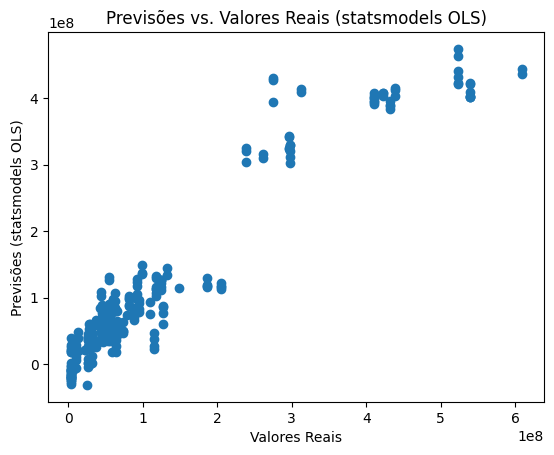

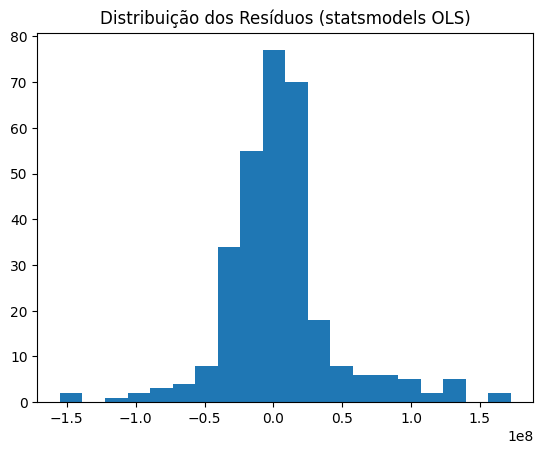

In [17]:
# Gráfico de resíduos (erros) para o modelo OLS
plt.scatter(y_test, y_pred_sm)
plt.xlabel("Valores Reais")
plt.ylabel("Previsões (statsmodels OLS)")
plt.title("Previsões vs. Valores Reais (statsmodels OLS)")
plt.show()

# Histograma dos resíduos para o modelo OLS
residuos_sm = y_test - y_pred_sm
plt.hist(residuos_sm, bins=20)
plt.title("Distribuição dos Resíduos (statsmodels OLS)")
plt.show()

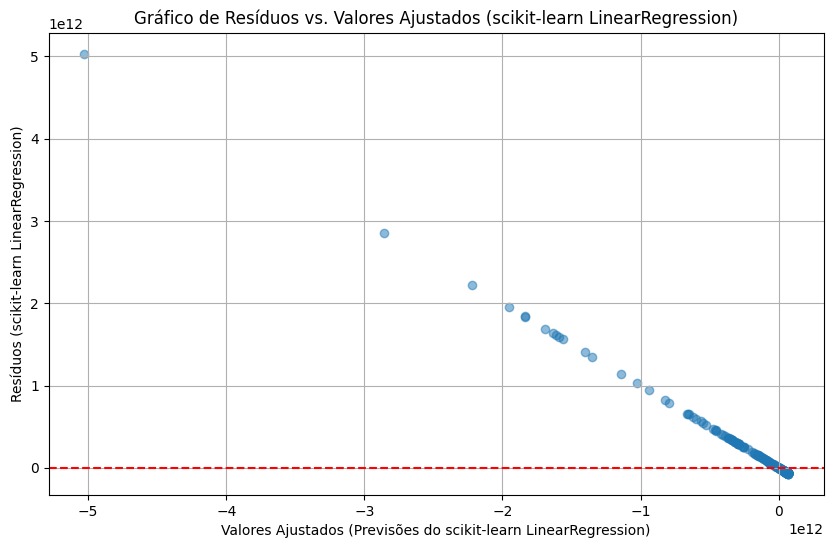

In [18]:
# # Gráfico de Resíduos vs. Valores Ajustados (scikit-learn LinearRegression)
# %%
# Calcular os resíduos para o modelo scikit-learn
residuos_sklearn = y_test - y_pred

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos_sklearn, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--') # Adicionar linha de referência em y=0
plt.xlabel("Valores Ajustados (Previsões do scikit-learn LinearRegression)")
plt.ylabel("Resíduos (scikit-learn LinearRegression)")
plt.title("Gráfico de Resíduos vs. Valores Ajustados (scikit-learn LinearRegression)")
plt.grid(True)
plt.show()

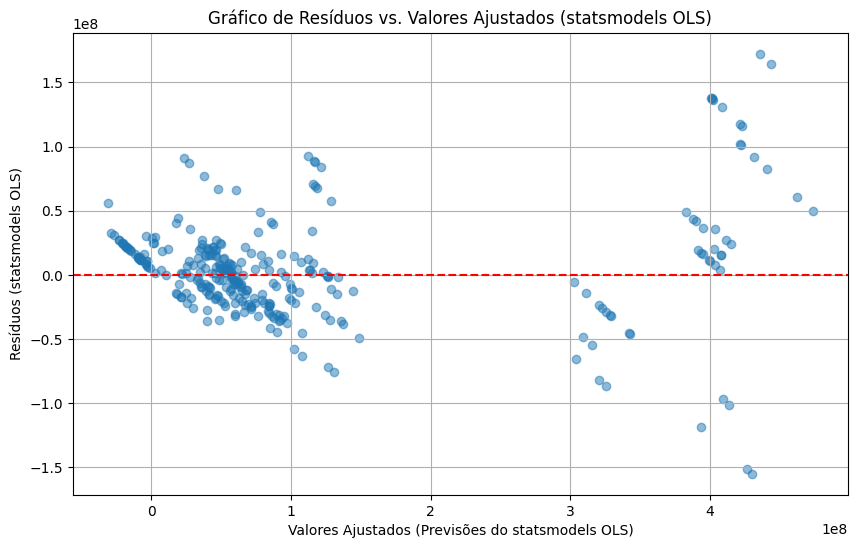

In [19]:
# # Gráfico de Resíduos vs. Valores Ajustados (statsmodels OLS)
# %%
# Calcular os resíduos (já calculados anteriormente, mas recalculando para clareza)
residuos_sm = y_test - y_pred_sm

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_sm, residuos_sm, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--') # Adicionar linha de referência em y=0
plt.xlabel("Valores Ajustados (Previsões do statsmodels OLS)")
plt.ylabel("Resíduos (statsmodels OLS)")
plt.title("Gráfico de Resíduos vs. Valores Ajustados (statsmodels OLS)")
plt.grid(True)
plt.show()

In [20]:
# Criar um dicionário com os dados
comparacao_data = {
    'Modelo': ['scikit-learn', 'statsmodels OLS'],
    'R²': [r2, r2_sm],
    'MSE': [mse, mse_sm]
}

# Criar um DataFrame pandas
comparacao_df = pd.DataFrame(comparacao_data)

# Exibir o DataFrame
display(comparacao_df)

,Modelo,R²,MSE
0,scikit-learn,-1.254717e+07,2.537294e+23
1,statsmodels OLS,9.137660e-01,1.743827e+15


/usr/local/lib/python3.11/dist-packages/statsmodels/graphics/regressionplots.py:566: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()
<ipython-input-22-59e972afb619>:2: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(pad=1.0)


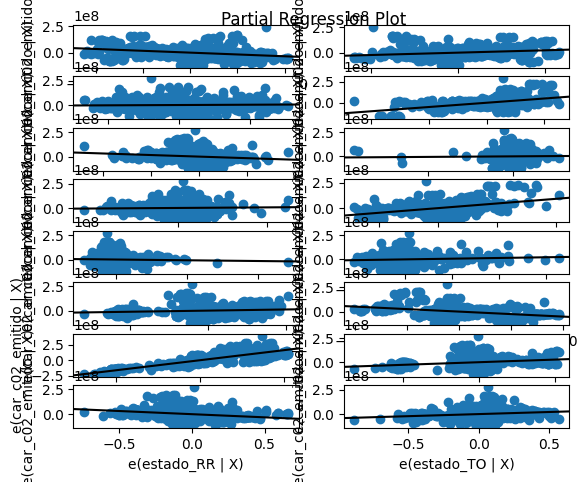

In [22]:
fig = sm.graphics.plot_partregress_grid(model_sm)
fig.tight_layout(pad=1.0)
plt.show()

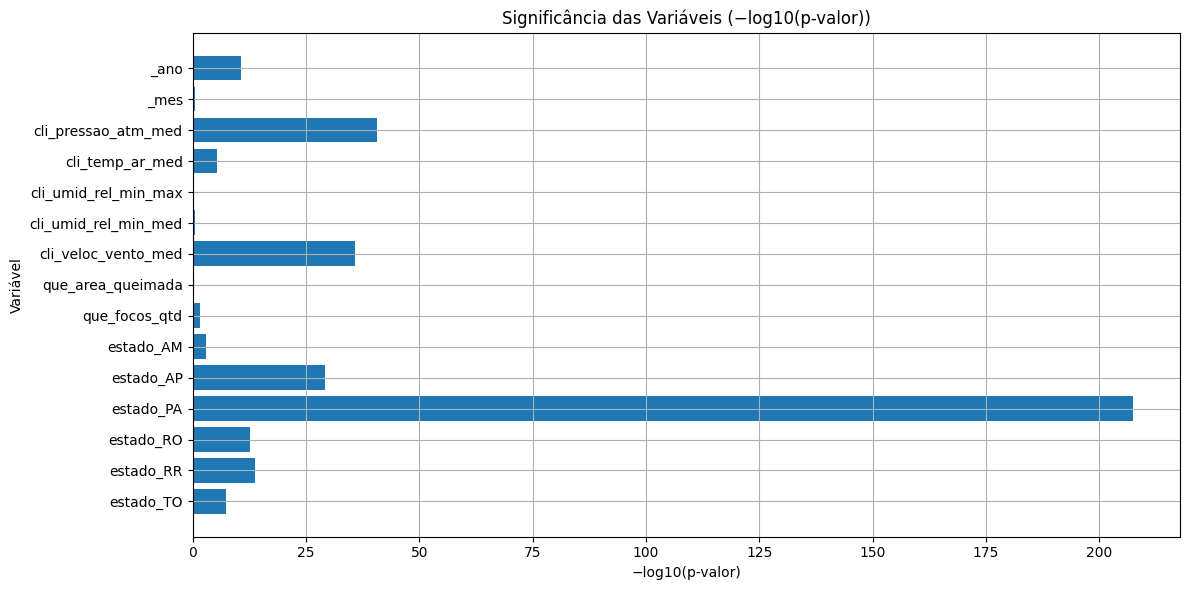

In [23]:
# Suponha que você tenha os p-valores no statsmodels.summary()
# 'model_sm' é o objeto summary do statsmodels treinado anteriormente
p_valores = model_sm.pvalues.drop("const")

plt.figure(figsize=(12, 6))
plt.barh(p_valores.index, -np.log10(p_valores.values))
plt.title('Significância das Variáveis (−log10(p-valor))')
plt.xlabel('−log10(p-valor)')
plt.ylabel('Variável')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()